## BAGIAN 1: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, 
    precision_score, recall_score, confusion_matrix
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Flower imports
import flwr as fl
from flwr.simulation import start_simulation
from flwr.server.strategy import FedAvg

# Local imports - import directly from current directory
from task import get_model_by_type
from utils import (
    split_data_non_iid_label,
    evaluate_model_metrics,
    prepare_client_configs,
    print_summary_table
)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ============================================================================
# KONFIGURASI EKSPERIMEN - UBAH DI SINI
# ============================================================================
NUM_ROUNDS = 10             # Jumlah putaran komunikasi federated learning
NUM_CLIENTS = 3             # Jumlah klien dalam sistem
LOCAL_EPOCHS = 3            # Jumlah epoch pelatihan lokal per klien per round
BATCH_SIZE_BINARY = 512     # Ukuran batch untuk model binary (optimized)
BATCH_SIZE_MULTI = 256      # Ukuran batch untuk model multi-class (optimized)
LEARNING_RATE = 0.001       # Learning rate untuk optimizer
SMOTE_TARGET_MITM = 3000    # Target jumlah sampel MITM setelah SMOTE
ALPHA_BINARY = 0.4          # Parameter alpha Dirichlet untuk data binary (Non-IID)
ALPHA_MULTI = 0.6           # Parameter alpha Dirichlet untuk data multi-class (Non-IID)
FRAMEWORK = "Flower (flwr)" # Framework yang digunakan
ALGORITHM = "Federated Averaging (FedAvg)"  # Algoritma federated learning
DATA_DISTRIBUTION = "Non-IID (Dirichlet)"   # Jenis distribusi data
# ============================================================================

print("=== FEDERATED AVERAGING (FEDAVG) DENGAN FLOWER ===")
print(f"Konfigurasi: {NUM_CLIENTS} Klien, {NUM_ROUNDS} Putaran, {LOCAL_EPOCHS} Local Epochs")
print(f"Batch Size - Binary: {BATCH_SIZE_BINARY}, Multi-class: {BATCH_SIZE_MULTI}")
print(f"SMOTE Target for MITM: {SMOTE_TARGET_MITM:,} samples")
print("Semua library berhasil diimpor.")
print(f"TensorFlow version: {tf.__version__}")
print(f"Flower version: {fl.__version__}")

2025-12-04 04:27:52.246953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


=== FEDERATED AVERAGING (FEDAVG) DENGAN FLOWER ===
Konfigurasi: 3 Klien, 10 Putaran, 3 Local Epochs
Batch Size - Binary: 512, Multi-class: 256
SMOTE Target for MITM: 3,000 samples
Semua library berhasil diimpor.
TensorFlow version: 2.20.0
Flower version: 1.24.0


## BAGIAN 2: PEMUATAN DATA

In [2]:
print("--- Memuat Dataset ---")
try:
    df = pd.read_csv(
        "/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/Cleaned Dataset/cleaned_train_test_network.csv"
    )
    print(f"Dataset berhasil dimuat. Shape: {df.shape}")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan path benar.")
    raise

--- Memuat Dataset ---
Dataset berhasil dimuat. Shape: (211043, 44)
Dataset berhasil dimuat. Shape: (211043, 44)


## BAGIAN 3: PREPARASI DATA

In [3]:
print("--- PREPARASI DATA UNTUK DETEKSI BINER ---")
df_binary = df.drop(columns=['src_ip','src_port','dst_ip','dst_port','type', 'weird_name','weird_addl','weird_notice'], errors='ignore')
X_binary = df_binary.drop('label', axis=1)
y_binary = df_binary['label']

for col in X_binary.select_dtypes(include=['object']).columns:
    X_binary[col] = LabelEncoder().fit_transform(X_binary[col])

# ✅ BENAR - Split → RFE → Scale (mencegah data leakage)
print("Step 1: Split data train/test untuk binary...")
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print("Step 2: Feature selection HANYA pada data training...")
n_features_bin = min(30, X_train_bin.shape[1])
rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
    n_features_to_select=n_features_bin
)
X_train_bin_selected = rfe.fit_transform(X_train_bin, y_train_bin)
X_test_bin_selected = rfe.transform(X_test_bin)  # Apply same feature selection to test

print("Step 3: Scale data - fit pada train, transform pada test...")
scaler_binary = StandardScaler()
X_train_bin_scaled = scaler_binary.fit_transform(X_train_bin_selected)
X_test_bin_scaled = scaler_binary.transform(X_test_bin_selected)

print(f"Data biner siap:")
print(f"  - Train: {X_train_bin_scaled.shape}")
print(f"  - Test: {X_test_bin_scaled.shape}")

gc.collect()

print("\n--- PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS ---")
df_multi = df.drop(columns=['src_ip','src_port','dst_ip','dst_port', 'label', 'weird_name','weird_addl','weird_notice'], errors='ignore')
y_multi = df_multi['type']
X_multi = df_multi.drop('type', axis=1)

le_target = LabelEncoder()
y_multi_encoded = le_target.fit_transform(y_multi)
num_classes = len(le_target.classes_)
print(f"Jumlah kelas: {num_classes}, Nama kelas: {list(le_target.classes_)}")

for col in X_multi.select_dtypes(include=['object']).columns:
    X_multi[col] = LabelEncoder().fit_transform(X_multi[col])

# ✅ BENAR - Split → SMOTE → RFE → Scale (mencegah data leakage)
print("Step 1: Split data train/test untuk multi-class...")
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi_encoded, test_size=0.2, random_state=42, stratify=y_multi_encoded
)

# Display class distribution BEFORE SMOTE
print("\n📊 Distribusi kelas SEBELUM SMOTE (Training Data):")
unique, counts = np.unique(y_train_multi, return_counts=True)
class_dist_before = dict(zip(unique, counts))
for class_idx, count in sorted(class_dist_before.items()):
    class_name = le_target.classes_[class_idx]
    print(f"   • {class_name}: {count:,} sampel")
print(f"   TOTAL: {len(y_train_multi):,} sampel")

# Step 2: Apply SMOTE to oversample MITM attacks (and potentially other minorities)
print("\nStep 2: Applying SMOTE untuk oversampling kelas minoritas...")
print(f"   Target: MITM attack dari ~833 → {SMOTE_TARGET_MITM:,} sampel")

# Define sampling strategy: oversample MITM to target, keep others as is
mitm_idx = list(le_target.classes_).index('mitm')
sampling_strategy = {mitm_idx: SMOTE_TARGET_MITM}

# Check if we have enough neighbors for SMOTE
mitm_count = class_dist_before.get(mitm_idx, 0)
k_neighbors = min(5, mitm_count - 1) if mitm_count > 1 else 1

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# Display class distribution AFTER SMOTE
print("\n📊 Distribusi kelas SETELAH SMOTE (Training Data):")
unique, counts = np.unique(y_train_multi_resampled, return_counts=True)
class_dist_after = dict(zip(unique, counts))
for class_idx, count in sorted(class_dist_after.items()):
    class_name = le_target.classes_[class_idx]
    before_count = class_dist_before.get(class_idx, 0)
    change = count - before_count
    if change > 0:
        print(f"   • {class_name}: {count:,} sampel (+{change:,} synthetic) ⬆️")
    else:
        print(f"   • {class_name}: {count:,} sampel")
print(f"   TOTAL: {len(y_train_multi_resampled):,} sampel (+{len(y_train_multi_resampled) - len(y_train_multi):,} synthetic)")

print("\nStep 3: Feature selection HANYA pada data training (post-SMOTE)...")
n_features_multi = min(35, X_train_multi_resampled.shape[1])
rfe_multi = RFE(
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
    n_features_to_select=n_features_multi
)
X_train_multi_selected = rfe_multi.fit_transform(X_train_multi_resampled, y_train_multi_resampled)
X_test_multi_selected = rfe_multi.transform(X_test_multi)  # Apply same feature selection to test

print("Step 4: Scale data - fit pada train (post-SMOTE), transform pada test...")
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi_selected)
X_test_multi_scaled = scaler_multi.transform(X_test_multi_selected)

print(f"\nData multi-kelas siap:")
print(f"  - Train: {X_train_multi_scaled.shape} (dengan SMOTE)")
print(f"  - Test: {X_test_multi_scaled.shape} (tanpa SMOTE)")

gc.collect()

--- PREPARASI DATA UNTUK DETEKSI BINER ---
Step 1: Split data train/test untuk binary...
Step 2: Feature selection HANYA pada data training...
Step 1: Split data train/test untuk binary...
Step 2: Feature selection HANYA pada data training...
Step 3: Scale data - fit pada train, transform pada test...
Data biner siap:
  - Train: (168834, 30)
  - Test: (42209, 30)

--- PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS ---
Step 3: Scale data - fit pada train, transform pada test...
Data biner siap:
  - Train: (168834, 30)
  - Test: (42209, 30)

--- PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS ---
Jumlah kelas: 10, Nama kelas: ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']
Jumlah kelas: 10, Nama kelas: ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']
Step 1: Split data train/test untuk multi-class...

📊 Distribusi kelas SEBELUM SMOTE (Training Data):
   • backdoor: 16,000 sampel
   •

24

## BAGIAN 4: SPLIT DATA KE KLIEN (NON-IID)

In [4]:
# Split data untuk klien menggunakan konfigurasi alpha yang sudah didefinisikan
# Gunakan data TRAINING yang sudah di-scale (bukan semua data)
# PENTING: Untuk multi-class, gunakan data yang sudah di-SMOTE
client_data_binary = split_data_non_iid_label(X_train_bin_scaled, y_train_bin, n_clients=NUM_CLIENTS, alpha=ALPHA_BINARY)
client_data_multi = split_data_non_iid_label(X_train_multi_scaled, y_train_multi_resampled, n_clients=NUM_CLIENTS, alpha=ALPHA_MULTI)

print(f"\n✅ Data test sudah siap dari cell sebelumnya:")
print(f"   - Binary Test: {X_test_bin_scaled.shape}")
print(f"   - Multi-class Test: {X_test_multi_scaled.shape}")
print(f"\n✅ Data training dengan SMOTE telah didistribusikan ke {NUM_CLIENTS} klien (Non-IID)")


[INFO] Splitting data for 3 clients with Non-IID (alpha=0.4)...
    Client 1: 40199 samples, distribution: {np.int64(0): np.int64(33298), np.int64(1): np.int64(6901)}
    Client 2: 127540 samples, distribution: {np.int64(0): np.int64(6115), np.int64(1): np.int64(121425)}
    Client 3: 1095 samples, distribution: {np.int64(0): np.int64(587), np.int64(1): np.int64(508)}

[INFO] Splitting data for 3 clients with Non-IID (alpha=0.6)...
    Client 1: 47018 samples, distribution: {np.int64(0): np.int64(3836), np.int64(1): np.int64(7949), np.int64(2): np.int64(3701), np.int64(3): np.int64(5904), np.int64(4): np.int64(481), np.int64(5): np.int64(664), np.int64(6): np.int64(9372), np.int64(7): np.int64(3964), np.int64(8): np.int64(249), np.int64(9): np.int64(10898)}
    Client 2: 59329 samples, distribution: {np.int64(0): np.int64(5010), np.int64(1): np.int64(12), np.int64(2): np.int64(9911), np.int64(3): np.int64(7762), np.int64(4): np.int64(962), np.int64(5): np.int64(14972), np.int64(6): np

## BAGIAN 5: DEFINISI FUNGSI UNTUK FLOWER CLIENT

In [5]:
class FlowerClient(fl.client.NumPyClient):
    """Flower client untuk federated learning."""
    
    def __init__(self, client_id, X_train, y_train, X_test, y_test, 
                 model_type, input_shape, num_classes, config):
        self.client_id = client_id
        self.X_train = X_train.astype(np.float32)
        self.y_train = y_train
        self.X_test = X_test.astype(np.float32) if X_test is not None else None
        self.y_test = y_test
        self.model_type = model_type
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.config = config
        self.model = None
        
        # Untuk CNN, reshape input
        if 'cnn' in model_type:
            self.X_train = self.X_train.reshape(-1, input_shape, 1)
            if self.X_test is not None:
                self.X_test = self.X_test.reshape(-1, input_shape, 1)
    
    def get_parameters(self, config):
        """Return model parameters."""
        if self.model is None:
            self.model = get_model_by_type(
                self.model_type, self.input_shape, 
                self.num_classes, self.config['learning_rate']
            )
        return self.model.get_weights()
    
    def set_parameters(self, parameters):
        """Set model parameters."""
        if self.model is None:
            self.model = get_model_by_type(
                self.model_type, self.input_shape, 
                self.num_classes, self.config['learning_rate']
            )
        self.model.set_weights(parameters)
    
    def fit(self, parameters, config):
        """Train model on local data."""
        self.set_parameters(parameters)
        
        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=self.config['local_epochs'],
            batch_size=self.config['batch_size'],
            verbose=0
        )
        
        # Return updated model parameters and metrics
        metrics = {
            "train_loss": history.history['loss'][-1],
            "train_acc": history.history['accuracy'][-1]
        }
        
        return self.get_parameters(config), len(self.X_train), metrics
    
    def evaluate(self, parameters, config):
        """Evaluate model on local test data."""
        if self.X_test is None:
            return 0.0, 0, {}
        
        self.set_parameters(parameters)
        
        loss, accuracy = self.model.evaluate(
            self.X_test, self.y_test, 
            batch_size=self.config['batch_size'], 
            verbose=0
        )
        
        return loss, len(self.X_test), {"eval_acc": accuracy}


def create_client_fn(client_data, test_data, model_type, input_shape, num_classes, config):
    """Factory function to create Flower clients."""
    X_test, y_test = test_data
    
    def client_fn(cid: str) -> FlowerClient:
        client_id = int(cid)
        X_train, y_train = client_data[client_id]
        
        return FlowerClient(
            client_id, X_train, y_train, X_test, y_test,
            model_type, input_shape, num_classes, config
        )
    
    return client_fn

print("✅ Flower client class dan factory function didefinisikan")

✅ Flower client class dan factory function didefinisikan


## BAGIAN 6: FUNGSI PELATIHAN FEDERATED DENGAN FLOWER

In [6]:
def run_federated_learning_flower(
    client_data,
    test_data,
    model_type,
    input_shape,
    num_classes,
    num_rounds=5,
    num_clients=3,
    local_epochs=1,
    batch_size=256,
    learning_rate=0.001,
    fraction_fit=1.0,
    fraction_evaluate=1.0
):
    """Run federated learning using Flower simulation.
    
    Args:
        client_data: List of (X, y) tuples for each client
        test_data: Tuple of (X_test, y_test) for evaluation
        model_type: Type of model to use
        input_shape: Number of input features
        num_classes: Number of output classes
        num_rounds: Number of federated rounds
        num_clients: Number of clients
        local_epochs: Epochs per client per round
        batch_size: Batch size for training
        learning_rate: Learning rate
        fraction_fit: Fraction of clients for training
        fraction_evaluate: Fraction of clients for evaluation
        
    Returns:
        Tuple of (final_model, history)
    """
    print(f"\n[INFO] Starting Flower federated learning for {model_type}...")
    print(f"   Clients: {num_clients} | Rounds: {num_rounds} | Local epochs: {local_epochs}")
    
    # Configuration
    config = {
        'local_epochs': local_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
    
    # Create client factory
    client_fn = create_client_fn(
        client_data, test_data, model_type, 
        input_shape, num_classes, config
    )
    
    # Create initial model to get parameters
    initial_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    initial_parameters = fl.common.ndarrays_to_parameters(initial_model.get_weights())
    
    # Define strategy with custom aggregation to track final weights and metrics
    final_weights = [None]  # Use list to allow mutation in nested function
    history_dict = {
        'train_accuracy': [],
        'train_loss': [],
        'eval_accuracy': [],
        'eval_loss': [],
        'round_time': [],
        'total_time': 0
    }
    
    round_start_time = [time.time()]  # Track round times
    
    class FedAvgWithWeights(FedAvg):
        def aggregate_fit(self, server_round, results, failures):
            round_time = time.time() - round_start_time[0]
            history_dict['round_time'].append(round_time)
            
            aggregated_result = super().aggregate_fit(server_round, results, failures)
            if aggregated_result is not None:
                final_weights[0] = aggregated_result[0]  # Store the parameters
                
                # Extract and aggregate training metrics from clients
                if results:
                    train_losses = [fit_res.metrics.get('train_loss', 0) for _, fit_res in results if 'train_loss' in fit_res.metrics]
                    train_accs = [fit_res.metrics.get('train_acc', 0) for _, fit_res in results if 'train_acc' in fit_res.metrics]
                    
                    if train_losses:
                        avg_loss = np.mean(train_losses)
                        history_dict['train_loss'].append(avg_loss)
                        print(f"      Round {server_round} - Avg Train Loss: {avg_loss:.4f}")
                    
                    if train_accs:
                        avg_acc = np.mean(train_accs)
                        history_dict['train_accuracy'].append(avg_acc)
                        print(f"      Round {server_round} - Avg Train Acc: {avg_acc:.4f} - Time: {round_time:.2f}s")
            
            # Reset timer for next round
            round_start_time[0] = time.time()
            return aggregated_result
        
        def aggregate_evaluate(self, server_round, results, failures):
            aggregated_result = super().aggregate_evaluate(server_round, results, failures)
            
            # Extract evaluation metrics
            if results:
                eval_losses = [eval_res.loss for _, eval_res in results]
                eval_accs = [eval_res.metrics.get('eval_acc', 0) for _, eval_res in results if 'eval_acc' in eval_res.metrics]
                
                if eval_losses:
                    avg_eval_loss = np.mean(eval_losses)
                    history_dict['eval_loss'].append(avg_eval_loss)
                
                if eval_accs:
                    avg_eval_acc = np.mean(eval_accs)
                    history_dict['eval_accuracy'].append(avg_eval_acc)
            
            return aggregated_result
    
    strategy = FedAvgWithWeights(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=max(2, int(num_clients * fraction_fit)),
        min_evaluate_clients=max(2, int(num_clients * fraction_evaluate)),
        min_available_clients=num_clients,
        initial_parameters=initial_parameters,
    )
    
    # Start simulation
    start_time = time.time()
    
    history = start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )
    
    total_time = time.time() - start_time
    history_dict['total_time'] = total_time
    
    # Get final model
    final_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    
    # Set weights from the final aggregation
    if final_weights[0] is not None:
        parameters = fl.common.parameters_to_ndarrays(final_weights[0])
        final_model.set_weights(parameters)
        print(f"   ✓ Model weights updated from federated training")
    else:
        print(f"   ⚠ Warning: Using initial model weights")
    
    print(f"\n✅ Federated learning completed in {total_time:.2f}s")
    print(f"   📊 Captured {len(history_dict['train_accuracy'])} rounds of training metrics")
    print(f"   ⏱️  Avg time per round: {np.mean(history_dict['round_time']):.2f}s")
    
    return final_model, history_dict

print("✅ Fungsi federated learning Flower didefinisikan")

✅ Fungsi federated learning Flower didefinisikan


## BAGIAN 7: PELATIHAN SEMUA MODEL

In [7]:
print("\n" + "="*70)
print("MEMULAI PELATIHAN FEDERATED AVERAGING (FEDAVG) DENGAN FLOWER")
print("="*70)

all_models = {}
all_histories = {}
all_metrics = {}

# Training Binary Models
print("\n--- PELATIHAN DETEKSI BINER DENGAN FLOWER ---")

print("\n⚙️ Melatih Model MLP Binary...")
all_models['mlp_binary'], all_histories['mlp_binary'] = run_federated_learning_flower(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'mlp_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE
)

print("\n⚙️ Melatih Model CNN Binary...")
all_models['cnn_binary'], all_histories['cnn_binary'] = run_federated_learning_flower(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'cnn_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE
)

# Training Multi-class Models
print("\n--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FLOWER ---")

print("\n⚙️ Melatih Model MLP Multi-class...")
all_models['mlp_multi'], all_histories['mlp_multi'] = run_federated_learning_flower(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'mlp_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE
)

print("\n⚙️ Melatih Model CNN Multi-class...")
all_models['cnn_multi'], all_histories['cnn_multi'] = run_federated_learning_flower(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'cnn_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE
)

print("\n✅ Semua model berhasil dilatih!")


MEMULAI PELATIHAN FEDERATED AVERAGING (FEDAVG) DENGAN FLOWER

--- PELATIHAN DETEKSI BINER DENGAN FLOWER ---

⚙️ Melatih Model MLP Binary...

[INFO] Starting Flower federated learning for mlp_binary...
   Clients: 3 | Rounds: 10 | Local epochs: 3


/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764797294.537677  564439 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2095 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :  

      Round 1 - Avg Train Loss: 0.3497
      Round 1 - Avg Train Acc: 0.9193 - Time: 11.92s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 5x a

      Round 2 - Avg Train Loss: 0.1425
      Round 2 - Avg Train Acc: 0.9513 - Time: 5.04s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=564978) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

      Round 3 - Avg Train Loss: 0.1154
      Round 3 - Avg Train Acc: 0.9545 - Time: 5.11s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=564978) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

      Round 4 - Avg Train Loss: 0.1169
      Round 4 - Avg Train Acc: 0.9539 - Time: 5.07s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=564978) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

      Round 5 - Avg Train Loss: 0.1143
      Round 5 - Avg Train Acc: 0.9543 - Time: 5.04s


(ClientAppActor pid=564981) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564981)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564981)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564981) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=564981) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

      Round 6 - Avg Train Loss: 0.1147
      Round 6 - Avg Train Acc: 0.9535 - Time: 4.96s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=564980) 
(ClientAppActor pid=564980)         
(ClientAppActor pid=564980) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=564980)             This is a deprecated feature. It will be removed [repeated 7x across cluster]
(ClientAppActor pid=564980)             entirely in future versions of Flower. [repeated 7x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

      Round 7 - Avg Train Loss: 0.1126
      Round 7 - Avg Train Acc: 0.9552 - Time: 4.96s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=564981) 
(ClientAppActor pid=564981)         
(ClientAppActor pid=564981) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564981)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564981)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564981) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

      Round 8 - Avg Train Loss: 0.1144
      Round 8 - Avg Train Acc: 0.9548 - Time: 5.00s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=564980) 
(ClientAppActor pid=564980)         
(ClientAppActor pid=564981) 
(ClientAppActor pid=564981)         
(ClientAppActor pid=564981) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=564981)             This is a deprecated feature. It will be removed [repeated 7x across cluster]
(ClientAppActor pid=564981)             entirely in future versions of Flower. [repeated 7x across cluster]
(ClientAppActor pid=564981) WARNING :   Deprecation Warning: The `clie

      Round 9 - Avg Train Loss: 0.1142
      Round 9 - Avg Train Acc: 0.9543 - Time: 5.13s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=564978) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

      Round 10 - Avg Train Loss: 0.1103
      Round 10 - Avg Train Acc: 0.9532 - Time: 5.34s


(ClientAppActor pid=564978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=564978)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=564978)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=564978) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=564978) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

   ✓ Model weights updated from federated training

✅ Federated learning completed in 58.11s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 5.76s

⚙️ Melatih Model CNN Binary...

[INFO] Starting Flower federated learning for cnn_binary...
   Clients: 3 | Rounds: 10 | Local epochs: 3


2025-12-04 04:29:16,599	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 28492791399.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:192.168.0.129': 1.0, 'CPU': 6.0, 'node:__internal_head__': 1.0, 'object_store_memory': 12211196313.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Ray initialized with resources: {'memory': 28492791399.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:192.168.0.129': 1.0, 'CPU': 6.0, 'node:__internal_head__': 1.0, 'object_store_memory': 12211196313.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal re

      Round 1 - Avg Train Loss: 0.2491
      Round 1 - Avg Train Acc: 0.8920 - Time: 21.66s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(pid=gcs_server) [2025-12-04 04:29:44,834 E 568735 568735] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=568872) WARNING 

      Round 2 - Avg Train Loss: 0.1183
      Round 2 - Avg Train Acc: 0.9566 - Time: 14.11s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568869) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=568869)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=568869)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=568869) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

      Round 3 - Avg Train Loss: 0.1041
      Round 3 - Avg Train Acc: 0.9685 - Time: 14.00s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientApp

      Round 4 - Avg Train Loss: 0.0814
      Round 4 - Avg Train Acc: 0.9739 - Time: 14.00s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientApp

      Round 5 - Avg Train Loss: 0.0832
      Round 5 - Avg Train Acc: 0.9744 - Time: 13.94s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientApp

      Round 6 - Avg Train Loss: 0.0744
      Round 6 - Avg Train Acc: 0.9771 - Time: 13.89s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientApp

      Round 7 - Avg Train Loss: 0.0742
      Round 7 - Avg Train Acc: 0.9741 - Time: 15.88s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientApp

      Round 8 - Avg Train Loss: 0.0616
      Round 8 - Avg Train Acc: 0.9742 - Time: 14.35s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientApp

      Round 9 - Avg Train Loss: 0.0606
      Round 9 - Avg Train Acc: 0.9752 - Time: 14.36s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientAppActor pid=568871) 
(ClientAppActor pid=568871)         
(ClientAppActor pid=568872) 
(ClientAppActor pid=568872)         
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=568869) 
(ClientAppActor pid=568869)         
(ClientA

      Round 10 - Avg Train Loss: 0.0545
      Round 10 - Avg Train Acc: 0.9752 - Time: 13.96s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 145.86s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2632683217525482
INFO :      		round 2: 0.14493054151535034
INFO :      		round 3: 0.10357426106929779
INFO :      		round 4: 0.19686290621757507
INFO :      		round 5: 0.09697309881448746
INFO :      		round 6: 0.13002276420593262
INFO :      		round 7: 0.11250890046358109
INFO :      		round 8: 0.09152265638113022
INFO :      		round 9: 0.08710300922393799
INFO :      		round 10: 0.09722057729959488
INFO :      
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 145.86s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.2632683217525482
INFO :      		round 2: 0.14493054151535034
INFO :      		round 3: 0.10357426106929779
INFO :      		round 4: 0.19686290621757507
INFO :      		round 5: 0.09697309881448746
INFO :      		round 6: 0.13

   ✓ Model weights updated from federated training

✅ Federated learning completed in 151.26s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 15.01s

--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FLOWER ---

⚙️ Melatih Model MLP Multi-class...

[INFO] Starting Flower federated learning for mlp_multi...
   Clients: 3 | Rounds: 10 | Local epochs: 3


2025-12-04 04:31:47,973	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 6.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:192.168.0.129': 1.0, 'memory': 28580501914.0, 'node:__internal_head__': 1.0, 'object_store_memory': 12248786534.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 6.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:192.168.0.129': 1.0, 'memory': 28580501914.0, 'node:__internal_head__': 1.0, 'object_store_memory': 12248786534.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal re

      Round 1 - Avg Train Loss: 0.8608
      Round 1 - Avg Train Acc: 0.7288 - Time: 15.98s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientApp

      Round 2 - Avg Train Loss: 0.6991
      Round 2 - Avg Train Acc: 0.7549 - Time: 8.48s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(pid=gcs_server) [2025-12-04 04:32:16,203 E 573058 573058] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=573184) WARNING 

      Round 3 - Avg Train Loss: 0.6635
      Round 3 - Avg Train Acc: 0.7673 - Time: 8.94s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573181) [2025-12-04 04:32:19,515 E 573181 573224] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=573181) [2025-12-04 04:32:

      Round 4 - Avg Train Loss: 0.6090
      Round 4 - Avg Train Acc: 0.7907 - Time: 8.84s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientApp

      Round 5 - Avg Train Loss: 0.5919
      Round 5 - Avg Train Acc: 0.7969 - Time: 9.27s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientApp

      Round 6 - Avg Train Loss: 0.5770
      Round 6 - Avg Train Acc: 0.8016 - Time: 8.48s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientApp

      Round 7 - Avg Train Loss: 0.5669
      Round 7 - Avg Train Acc: 0.8038 - Time: 8.71s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientApp

      Round 8 - Avg Train Loss: 0.5561
      Round 8 - Avg Train Acc: 0.8075 - Time: 8.62s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientApp

      Round 9 - Avg Train Loss: 0.5482
      Round 9 - Avg Train Acc: 0.8102 - Time: 9.11s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientAppActor pid=573185) 
(ClientAppActor pid=573185)         
(ClientAppActor pid=573184) 
(ClientAppActor pid=573184)         
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=573182) 
(ClientAppActor pid=573182)         
(ClientA

      Round 10 - Avg Train Loss: 0.5465
      Round 10 - Avg Train Acc: 0.8100 - Time: 8.77s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 90.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.251038670539856
INFO :      		round 2: 0.8741818070411682
INFO :      		round 3: 0.7892259359359741
INFO :      		round 4: 0.7398281693458557
INFO :      		round 5: 0.6913997530937195
INFO :      		round 6: 0.6417493224143982
INFO :      		round 7: 0.629112720489502
INFO :      		round 8: 0.6156886219978333
INFO :      		round 9: 0.6022193431854248
INFO :      		round 10: 0.6056862473487854
INFO :      
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 90.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.251038670539856
INFO :      		round 2: 0.8741818070411682
INFO :      		round 3: 0.7892259359359741
INFO :      		round 4: 0.7398281693458557
INFO :      		round 5: 0.6913997530937195
INFO :      		round 6: 0.6417493224143982
INF

   ✓ Model weights updated from federated training

✅ Federated learning completed in 96.08s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 9.52s

⚙️ Melatih Model CNN Multi-class...

[INFO] Starting Flower federated learning for cnn_multi...
   Clients: 3 | Rounds: 10 | Local epochs: 3


2025-12-04 04:33:24,290	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 6.0, 'node:192.168.0.129': 1.0, 'memory': 28494721024.0, 'object_store_memory': 12212023296.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 6.0, 'node:192.168.0.129': 1.0, 'memory': 28494721024.0, 'object_store_memory': 12212023296.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal re

      Round 1 - Avg Train Loss: 0.7012
      Round 1 - Avg Train Acc: 0.7349 - Time: 35.67s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577595) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=577595)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=577595)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=577595) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

      Round 2 - Avg Train Loss: 0.6372
      Round 2 - Avg Train Acc: 0.7565 - Time: 28.98s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 3 - Avg Train Loss: 0.5973
      Round 3 - Avg Train Acc: 0.7697 - Time: 28.73s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 4 - Avg Train Loss: 0.5710
      Round 4 - Avg Train Acc: 0.7803 - Time: 28.48s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 5 - Avg Train Loss: 0.5471
      Round 5 - Avg Train Acc: 0.7879 - Time: 31.02s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 6 - Avg Train Loss: 0.5198
      Round 6 - Avg Train Acc: 0.7991 - Time: 28.58s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 7 - Avg Train Loss: 0.4876
      Round 7 - Avg Train Acc: 0.8143 - Time: 28.94s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 8 - Avg Train Loss: 0.4766
      Round 8 - Avg Train Acc: 0.8220 - Time: 28.43s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientApp

      Round 9 - Avg Train Loss: 0.4588
      Round 9 - Avg Train Acc: 0.8294 - Time: 28.36s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientAppActor pid=577596) 
(ClientAppActor pid=577596)         
(ClientAppActor pid=577591) 
(ClientAppActor pid=577591)         
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=577595) 
(ClientAppActor pid=577595)         
(ClientA

      Round 10 - Avg Train Loss: 0.4596
      Round 10 - Avg Train Acc: 0.8269 - Time: 28.79s


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 292.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.4889957904815674
INFO :      		round 2: 1.4267401695251465
INFO :      		round 3: 1.1066020727157593
INFO :      		round 4: 1.0887048244476318
INFO :      		round 5: 1.7744616270065308
INFO :      		round 6: 1.2682926654815674
INFO :      		round 7: 1.31141197681427
INFO :      		round 8: 2.2152657508850098
INFO :      		round 9: 4.39304256439209
INFO :      		round 10: 4.208043575286865
INFO :      
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 292.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.4889957904815674
INFO :      		round 2: 1.4267401695251465
INFO :      		round 3: 1.1066020727157593
INFO :      		round 4: 1.0887048244476318
INFO :      		round 5: 1.7744616270065308
INFO :      		round 6: 1.2682926654815674
INF

   ✓ Model weights updated from federated training

✅ Federated learning completed in 297.77s
   📊 Captured 10 rounds of training metrics
   ⏱️  Avg time per round: 29.60s

✅ Semua model berhasil dilatih!


## BAGIAN 8: EVALUASI MODEL

In [8]:
print("\n" + "="*70)
print("📊 EVALUASI SEMUA MODEL")
print("="*70)

# Evaluate Binary Models
print("\n--- EVALUASI MODEL BINARY ---")

# MLP Binary - gunakan data test yang sudah di-scale dengan benar
X_test_eval = X_test_bin_scaled.astype(np.float32)
y_pred_prob = all_models['mlp_binary'].predict(X_test_eval, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['MLP Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "MLP Binary", is_binary=True,
    target_names=['Normal', 'Attack']
)
# Store predictions for confusion matrix
all_metrics['MLP Binary']['predictions'] = y_pred

print(f"\n   MLP Binary Performance:")
print(f"   • Accuracy:  {all_metrics['MLP Binary']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['MLP Binary']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['MLP Binary']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['MLP Binary']['f1_score']:.4f}")

# CNN Binary - gunakan data test yang sudah di-scale dengan benar
X_test_eval_cnn = X_test_bin_scaled.reshape(-1, X_train_bin_scaled.shape[1], 1).astype(np.float32)
y_pred_prob = all_models['cnn_binary'].predict(X_test_eval_cnn, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['CNN Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "CNN Binary", is_binary=True,
    target_names=['Normal', 'Attack']
)
# Store predictions for confusion matrix
all_metrics['CNN Binary']['predictions'] = y_pred

print(f"\n   CNN Binary Performance:")
print(f"   • Accuracy:  {all_metrics['CNN Binary']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['CNN Binary']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['CNN Binary']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['CNN Binary']['f1_score']:.4f}")

# Evaluate Multi-class Models
print("\n--- EVALUASI MODEL MULTI-CLASS ---")

# MLP Multi - gunakan data test yang sudah di-scale dengan benar
X_test_eval = X_test_multi_scaled.astype(np.float32)
y_pred_prob = all_models['mlp_multi'].predict(X_test_eval, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['MLP Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "MLP Multi", is_binary=False,
    target_names=le_target.classes_
)
# Store predictions for confusion matrix
all_metrics['MLP Multi']['predictions'] = y_pred

print(f"\n   MLP Multi Performance:")
print(f"   • Accuracy:  {all_metrics['MLP Multi']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['MLP Multi']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['MLP Multi']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['MLP Multi']['f1_score']:.4f}")

# CNN Multi - gunakan data test yang sudah di-scale dengan benar
X_test_eval_cnn = X_test_multi_scaled.reshape(-1, X_train_multi_scaled.shape[1], 1).astype(np.float32)
y_pred_prob = all_models['cnn_multi'].predict(X_test_eval_cnn, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['CNN Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "CNN Multi", is_binary=False,
    target_names=le_target.classes_
)
# Store predictions for confusion matrix
all_metrics['CNN Multi']['predictions'] = y_pred

print(f"\n   CNN Multi Performance:")
print(f"   • Accuracy:  {all_metrics['CNN Multi']['accuracy']:.4f}")
print(f"   • Precision: {all_metrics['CNN Multi']['precision']:.4f}")
print(f"   • Recall:    {all_metrics['CNN Multi']['recall']:.4f}")
print(f"   • F1-Score:  {all_metrics['CNN Multi']['f1_score']:.4f}")

# Print summary table
print("\n" + "="*70)
print_summary_table(all_metrics)
print("="*70)

# Display best models
best_binary_name = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Binary' in name],
    key=lambda x: x[1]['f1_score']
)[0]
best_multi_name = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Multi' in name],
    key=lambda x: x[1]['f1_score']
)[0]

print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"   • Binary Classification: {best_binary_name}")
print(f"   • Multi-class Classification: {best_multi_name}")


📊 EVALUASI SEMUA MODEL

--- EVALUASI MODEL BINARY ---


2025-12-04 04:38:19.053270: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1cf0001c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 04:38:19.053288: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-12-04 04:38:19.058176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 04:38:19.097420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764797899.382819  564810 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1764797899.382819  564810 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/elnoersan/Skripsi/Paper/.ve


📊 EVALUATION METRICS - MLP Binary:
   • Accuracy: 0.9547
   • Precision: 0.9452
   • Recall: 0.9985
   • F1 Score: 0.9711

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.99      0.81      0.89     10000
      Attack       0.95      1.00      0.97     32209

    accuracy                           0.95     42209
   macro avg       0.97      0.91      0.93     42209
weighted avg       0.96      0.95      0.95     42209


   MLP Binary Performance:
   • Accuracy:  0.9547
   • Precision: 0.9452
   • Recall:    0.9985
   • F1-Score:  0.9711


/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/utils/python_utils.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = float(value)



📊 EVALUATION METRICS - CNN Binary:
   • Accuracy: 0.9557
   • Precision: 0.9465
   • Recall: 0.9984
   • F1 Score: 0.9717

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.99      0.82      0.90     10000
      Attack       0.95      1.00      0.97     32209

    accuracy                           0.96     42209
   macro avg       0.97      0.91      0.93     42209
weighted avg       0.96      0.96      0.95     42209


   CNN Binary Performance:
   • Accuracy:  0.9557
   • Precision: 0.9465
   • Recall:    0.9984
   • F1-Score:  0.9717

--- EVALUASI MODEL MULTI-CLASS ---

📊 EVALUATION METRICS - MLP Multi:
   • Accuracy: 0.7875
   • Precision: 0.8512
   • Recall: 0.7875
   • F1 Score: 0.7790

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    backdoor       0.46      0.99      0.63      4000
        ddos       0.99      0.87      0.93      4000
         dos       0.91      0.14      0.24      4000
   

## BAGIAN 9: VISUALISASI HASIL


📊 VISUALISASI HASIL FLOWER FEDAVG

✅ Visualisasi disimpan sebagai 'flower_fedavg_results.png'

✅ Visualisasi disimpan sebagai 'flower_fedavg_results.png'


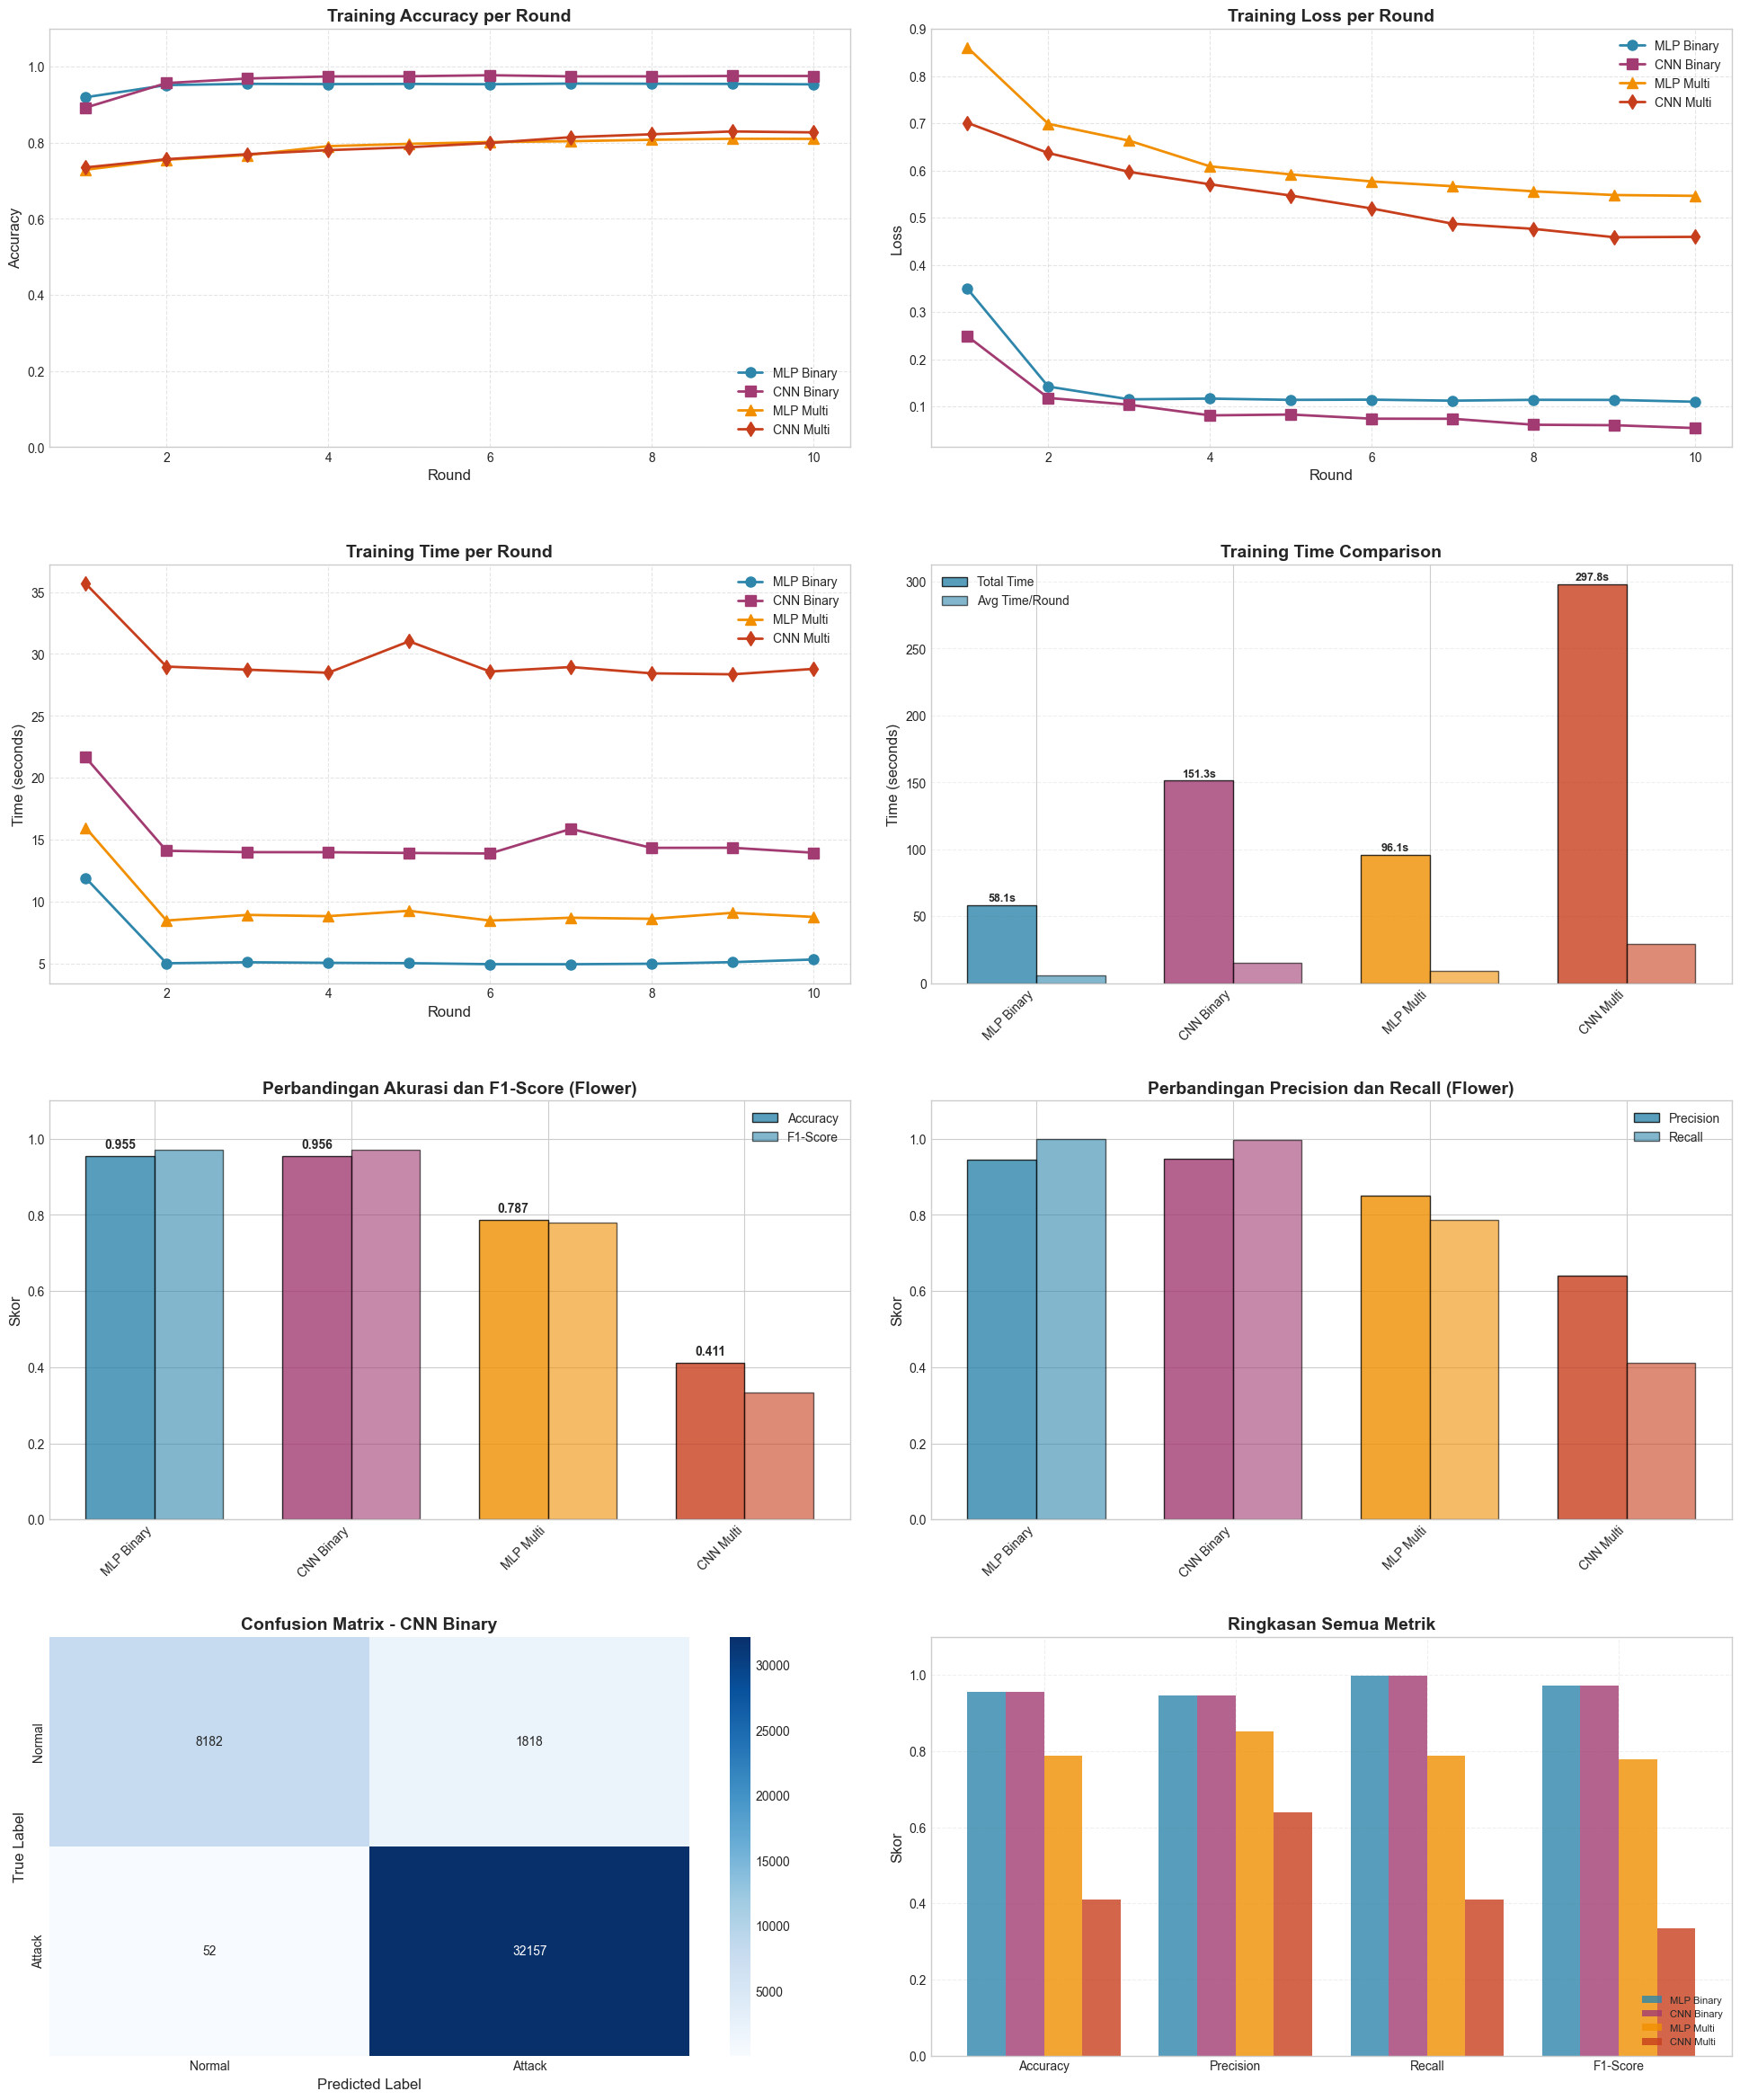

In [9]:
print("\n" + "="*70)
print("📊 VISUALISASI HASIL FLOWER FEDAVG")
print("="*70)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

model_names = ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']
model_keys = ['mlp_binary', 'cnn_binary', 'mlp_multi', 'cnn_multi']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']

# Plot 1: Training Accuracy per Round (Line Graph)
axes[0, 0].set_title('Training Accuracy per Round', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_accuracy']:
        rounds = list(range(1, len(all_histories[key]['train_accuracy']) + 1))
        axes[0, 0].plot(rounds, all_histories[key]['train_accuracy'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 0].set_xlabel('Round', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].set_ylim(0, 1.1)

# Plot 2: Training Loss per Round (Line Graph)
axes[0, 1].set_title('Training Loss per Round', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_loss']:
        rounds = list(range(1, len(all_histories[key]['train_loss']) + 1))
        axes[0, 1].plot(rounds, all_histories[key]['train_loss'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 1].set_xlabel('Round', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Round Time per Round (Line Graph)
axes[1, 0].set_title('Training Time per Round', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['round_time']:
        rounds = list(range(1, len(all_histories[key]['round_time']) + 1))
        axes[1, 0].plot(rounds, all_histories[key]['round_time'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[1, 0].set_xlabel('Round', fontsize=12)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Total Training Time Comparison (Bar Chart)
total_times = [all_histories[key]['total_time'] for key in model_keys]
avg_round_times = [np.mean(all_histories[key]['round_time']) for key in model_keys]

x_pos = np.arange(len(model_names))
width = 0.35

bars_total = axes[1, 1].bar(x_pos - width/2, total_times, width, label='Total Time', 
                            color=colors, alpha=0.8, edgecolor='black')
bars_avg = axes[1, 1].bar(x_pos + width/2, avg_round_times, width, label='Avg Time/Round', 
                          color=colors, alpha=0.6, edgecolor='black')

axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.3, axis='y')

for bar, t_time in zip(bars_total, total_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_times)*0.01, 
                    f'{t_time:.1f}s', ha='center', fontsize=9, fontweight='bold')

# Plot 5: Accuracy Comparison (Bar Chart)
accuracies = [all_metrics[name]['accuracy'] for name in model_names]
f1_scores = [all_metrics[name]['f1_score'] for name in model_names]

bars1 = axes[2, 0].bar(x_pos - width/2, accuracies, width, label='Accuracy', 
                       color=colors, alpha=0.8, edgecolor='black')
bars2 = axes[2, 0].bar(x_pos + width/2, f1_scores, width, label='F1-Score', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 0].set_title('Perbandingan Akurasi dan F1-Score (Flower)', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Skor', fontsize=12)
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 0].legend()
axes[2, 0].set_ylim(0, 1.1)

for bar, acc in zip(bars1, accuracies):
    axes[2, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{acc:.3f}', ha='center', fontweight='bold', fontsize=10)

# Plot 6: Precision vs Recall
precisions = [all_metrics[name]['precision'] for name in model_names]
recalls = [all_metrics[name]['recall'] for name in model_names]

bars3 = axes[2, 1].bar(x_pos - width/2, precisions, width, label='Precision', 
                       color=colors, alpha=0.8, edgecolor='black')
bars4 = axes[2, 1].bar(x_pos + width/2, recalls, width, label='Recall', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 1].set_title('Perbandingan Precision dan Recall (Flower)', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Skor', fontsize=12)
axes[2, 1].set_xticks(x_pos)
axes[2, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 1].legend()
axes[2, 1].set_ylim(0, 1.1)

# Plot 7: Confusion Matrix for Best Binary Model
best_binary = 'MLP Binary' if all_metrics['MLP Binary']['f1_score'] > all_metrics['CNN Binary']['f1_score'] else 'CNN Binary'
y_pred_best = all_metrics[best_binary]['predictions']
cm = confusion_matrix(y_test_bin, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[3, 0],
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
axes[3, 0].set_title(f'Confusion Matrix - {best_binary}', fontsize=14, fontweight='bold')
axes[3, 0].set_ylabel('True Label', fontsize=12)
axes[3, 0].set_xlabel('Predicted Label', fontsize=12)

# Plot 8: Model Comparison Summary
metrics_data = []
for name in model_names:
    metrics_data.append([
        all_metrics[name]['accuracy'],
        all_metrics[name]['precision'],
        all_metrics[name]['recall'],
        all_metrics[name]['f1_score']
    ])

x_metrics = np.arange(4)
bar_width = 0.2

for i, (name, data) in enumerate(zip(model_names, metrics_data)):
    axes[3, 1].bar(x_metrics + i*bar_width, data, bar_width, 
                   label=name, color=colors[i], alpha=0.8)

axes[3, 1].set_title('Ringkasan Semua Metrik', fontsize=14, fontweight='bold')
axes[3, 1].set_ylabel('Skor', fontsize=12)
axes[3, 1].set_xticks(x_metrics + bar_width * 1.5)
axes[3, 1].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[3, 1].legend(loc='lower right', fontsize=8)
axes[3, 1].set_ylim(0, 1.1)
axes[3, 1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.savefig('flower_fedavg_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualisasi disimpan sebagai 'flower_fedavg_results.png'")
plt.show()

## BAGIAN 10: LAPORAN AKHIR

In [10]:
print("\n" + "="*80)
print("📋 LAPORAN AKHIR - FEDERATED AVERAGING DENGAN FLOWER")
print("="*80)

print(f"\n📋 INFORMASI EKSPERIMEN:")
print(f"   • Framework: {FRAMEWORK}")
print(f"   • Algoritma: {ALGORITHM}")
print(f"   • Jumlah Klien: {NUM_CLIENTS}")
print(f"   • Distribusi Data: {DATA_DISTRIBUTION}")
print(f"   • Alpha Binary: {ALPHA_BINARY} | Alpha Multi-class: {ALPHA_MULTI}")
print(f"   • Putaran Komunikasi: {NUM_ROUNDS}")
print(f"   • Local Epochs: {LOCAL_EPOCHS}")
print(f"   • Batch Size Binary: {BATCH_SIZE_BINARY} | Batch Size Multi-class: {BATCH_SIZE_MULTI}")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • SMOTE Target (MITM): {SMOTE_TARGET_MITM:,} sampel")
print(f"   • Ukuran Dataset: {df.shape[0]:,} sampel")
print(f"   • Train/Test Split: 80/20 (stratified)")
print(f"   • Scaling Method: StandardScaler (fit pada train, transform pada test)")

print(f"\n📊 DISTRIBUSI DATA:")
print(f"   Binary Classification:")
print(f"   • Train: {X_train_bin_scaled.shape[0]:,} sampel → {NUM_CLIENTS} klien (Non-IID α={ALPHA_BINARY})")
print(f"   • Test: {X_test_bin_scaled.shape[0]:,} sampel (global evaluation)")
print(f"\n   Multi-class Classification (dengan SMOTE):")
print(f"   • Train: {X_train_multi_scaled.shape[0]:,} sampel → {NUM_CLIENTS} klien (Non-IID α={ALPHA_MULTI})")
print(f"   • Test: {X_test_multi_scaled.shape[0]:,} sampel (global evaluation, tanpa SMOTE)")

print(f"\n📊 DISTRIBUSI DATA KE KLIEN:")
for i, (X_client, y_client) in enumerate(client_data_binary):
    print(f"   • Klien {i+1} (Binary): {len(X_client):,} sampel")

print(f"\n⏱️  WAKTU PELATIHAN:")
model_names_keys = [
    ('MLP Binary', 'mlp_binary'),
    ('CNN Binary', 'cnn_binary'),
    ('MLP Multi', 'mlp_multi'),
    ('CNN Multi', 'cnn_multi')
]
total_training_time = sum(all_histories[key]['total_time'] for _, key in model_names_keys)

for name, key in model_names_keys:
    history = all_histories[key]
    print(f"   • {name}:")
    print(f"      - Total: {history['total_time']:.2f}s")
    print(f"      - Per Round (avg): {np.mean(history['round_time']):.2f}s")
    print(f"      - Per Round (min/max): {np.min(history['round_time']):.2f}s / {np.max(history['round_time']):.2f}s")

print(f"\n   • Total Waktu Pelatihan Semua Model: {total_training_time:.2f}s ({total_training_time/60:.2f} menit)")

print(f"\n🏆 MODEL TERBAIK:")
best_binary = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Binary' in name],
    key=lambda x: x[1]['f1_score']
)
best_multi = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Multi' in name],
    key=lambda x: x[1]['f1_score']
)

print(f"   📍 Klasifikasi Binary:")
print(f"      • Terbaik: {best_binary[0]}")
print(f"      • Accuracy: {best_binary[1]['accuracy']:.4f}")
print(f"      • Precision: {best_binary[1]['precision']:.4f}")
print(f"      • Recall: {best_binary[1]['recall']:.4f}")
print(f"      • F1-Score: {best_binary[1]['f1_score']:.4f}")

print(f"\n   📍 Klasifikasi Multi-class:")
print(f"      • Terbaik: {best_multi[0]}")
print(f"      • Accuracy: {best_multi[1]['accuracy']:.4f}")
print(f"      • Precision: {best_multi[1]['precision']:.4f}")
print(f"      • Recall: {best_multi[1]['recall']:.4f}")
print(f"      • F1-Score: {best_multi[1]['f1_score']:.4f}")

print(f"\n📈 RINGKASAN PERFORMA SEMUA MODEL:")
for name in ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']:
    metrics = all_metrics[name]
    print(f"   • {name}:")
    print(f"      - Accuracy: {metrics['accuracy']:.4f}")
    print(f"      - Precision: {metrics['precision']:.4f}")
    print(f"      - Recall: {metrics['recall']:.4f}")
    print(f"      - F1-Score: {metrics['f1_score']:.4f}")

print(f"\n💡 KESIMPULAN:")
print(f"   • Flower berhasil melatih {len(all_models)} model pada lingkungan Non-IID")
print(f"   • API Flower lebih sederhana dan intuitif dibanding TFF")
print(f"   • Simulasi mudah dijalankan dengan start_simulation()")
print(f"   • Model dapat dengan mudah di-deploy ke production")
print(f"   • Tracking metrik lebih straightforward")
print(f"   • ✅ DATA LEAKAGE PREVENTION: Split → SMOTE → RFE → Scale")
print(f"   • ✅ SMOTE diterapkan untuk mengatasi imbalance kelas MITM")

print(f"\n🔧 KEUNGGULAN FLOWER:")
print(f"   • API yang lebih bersih dan mudah dipahami")
print(f"   • Simulasi dan deployment yang fleksibel")
print(f"   • Support untuk berbagai framework ML (TF, PyTorch, etc)")
print(f"   • Community yang aktif dan dokumentasi yang baik")
print(f"   • Mudah dikustomisasi untuk kebutuhan spesifik")

print("\n✅ EKSPERIMEN FLOWER SELESAI")
print("="*80)


📋 LAPORAN AKHIR - FEDERATED AVERAGING DENGAN FLOWER

📋 INFORMASI EKSPERIMEN:
   • Framework: Flower (flwr)
   • Algoritma: Federated Averaging (FedAvg)
   • Jumlah Klien: 3
   • Distribusi Data: Non-IID (Dirichlet)
   • Alpha Binary: 0.4 | Alpha Multi-class: 0.6
   • Putaran Komunikasi: 10
   • Local Epochs: 3
   • Batch Size Binary: 512 | Batch Size Multi-class: 256
   • Learning Rate: 0.001
   • SMOTE Target (MITM): 3,000 sampel
   • Ukuran Dataset: 211,043 sampel
   • Train/Test Split: 80/20 (stratified)
   • Scaling Method: StandardScaler (fit pada train, transform pada test)

📊 DISTRIBUSI DATA:
   Binary Classification:
   • Train: 168,834 sampel → 3 klien (Non-IID α=0.4)
   • Test: 42,209 sampel (global evaluation)

   Multi-class Classification (dengan SMOTE):
   • Train: 171,000 sampel → 3 klien (Non-IID α=0.6)
   • Test: 42,209 sampel (global evaluation, tanpa SMOTE)

📊 DISTRIBUSI DATA KE KLIEN:
   • Klien 1 (Binary): 40,199 sampel
   • Klien 2 (Binary): 127,540 sampel
   • K